In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

(CVXPY) Nov 07 09:31:34 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [2]:
groupLabels = np.loadtxt('movies/groupLabelsPerRating.txt', delimiter=',')
groupLabels = np.insert(groupLabels, 0, values=0)

In [3]:
trainRatings = np.loadtxt('movies/trainRatings.txt', delimiter=',')
trainRatings = np.insert(trainRatings, 0, values=1, axis=1)

In [4]:
trainLabels = np.loadtxt('movies/trainLabels.txt', delimiter=',')

In [5]:
class Optimization:
    def __init__(self, X, y, groupLabels, LAMBDA=5, learning_rate=1e-4):
        self.X = X
        self.y = y
        self.LAMBDA = LAMBDA
        self.lr = learning_rate
        self.groupLabels = groupLabels
        
        self.beta0 = np.random.rand(X.shape[1])
        self.beta = np.zeros(X.shape[1])
        self.group, count = np.unique(groupLabels, return_counts=True)
        self.fk = np.empty(0)
        self.w = np.sqrt(count)
        
    def norm2(self, vector):
        return np.linalg.norm(vector)
    
    def proximal(self, betaj, wj, t):
        norm2 = self.norm2(betaj)
        if norm2 == 0:
            return betaj*0
        return betaj * np.maximum(0, 1-t*wj*self.LAMBDA/norm2)
    
    def gradient(self, beta):
        XBeta = self.X @ beta
        result = (np.exp(XBeta) / (1+np.exp(XBeta)) - self.y) @ self.X
        return result
    
    def g(self, beta):
        XBeta = self.X @ beta
        f1 = -self.y @ XBeta.T
        f2 = np.ones(XBeta.shape) @ np.log(1+np.exp(XBeta))
        return f1+f2
    
    def h(self, beta):
        S = 0
        for j in self.group:
            jbeta = (self.groupLabels==j)
            jw = (self.group==j)
            S += self.w[jw] * self.norm2(beta[jbeta])
        return self.LAMBDA * S
    
    def Fk(self, beta):
        gk = self.g(beta)
        hk = self.h(beta)
        return gk + hk
    
    def PGD(self, iteration=1000):
        self.fk = np.empty(0)
        self.fk = np.append(self.fk, self.Fk(self.beta0))
        beta = self.beta0.copy()
        
        for i in range(iteration):
            betaCopy = beta.copy()
            grad = self.gradient(betaCopy)
            for j in self.group:
                jbeta = (self.groupLabels==j)
                jw = (self.group==j)
                betaCopy[jbeta] = self.proximal(betaCopy[jbeta]-self.lr*grad[jbeta], self.w[jw], self.lr)
            beta = betaCopy.copy()
            
            self.fk = np.append(self.fk, self.Fk(betaCopy))
        self.beta = beta.copy()
            
    def NesterovPGD(self, iteration=1000):
        self.fk = np.empty(0)
        beta_1 = self.beta0.copy()
        self.fk = np.append(self.fk, self.Fk(self.beta0))
        beta = self.beta0.copy()
        
        for i in range(iteration):
            beta_2 = beta_1.copy()
            beta_1 = beta.copy()
            v = beta_1 + (i-2)/(i+1)*(beta_1-beta_2)
            grad = self.gradient(v)
            for j in self.group:
                jbeta = (self.groupLabels==j)
                jw = (self.group==j)
                beta[jbeta] = self.proximal(v[jbeta]-self.lr*grad[jbeta], self.w[jw], self.lr)
            
            self.fk = np.append(self.fk, self.Fk(beta))
        self.beta = beta.copy()
            
    def BacktrackingLineSearch(self, iteration=1000, t=1e-4):
        self.fk = np.empty(0)
        b = 0.1
        a = 0.5
        t = t
        self.fk = np.append(self.fk, self.Fk(self.beta0))
        beta = self.beta0.copy()
        
        for i in range(iteration):
            prox = beta.copy()
            grad = self.gradient(prox)
            for j in self.group:
                jbeta = (self.groupLabels==j)
                jw = (self.group==j)
                prox[jbeta] = self.proximal(prox[jbeta]-t*grad[jbeta], self.w[jw], t)
            
            G = 1/t * (beta - prox)
            gG = self.g(beta - t*G)
            gSq = self.g(beta) - t*grad@G + t/2*self.norm2(G)**2
            if gG > gSq:
                t = b*t
            else:
                beta = prox.copy()
            
            self.fk = np.append(self.fk, self.Fk(beta))
        self.beta = beta.copy()
            
    def NesterovBacktrackingLineSearch(self, iteration=1000, t=1e-4):
        self.fk = np.empty(0)
        b = 0.1
        a = 0.5
        t = t
        beta_1 = self.beta0.copy()
        self.fk = np.append(self.fk, self.Fk(self.beta0))
        beta = self.beta0.copy()
        betaCopy = beta.copy()
        
        for i in range(iteration):
            beta_2 = beta_1.copy()
            beta_1 = beta.copy()
            v = beta_1 + (i-2)/(i+1)*(beta_1-beta_2)
            grad = self.gradient(v)
            for j in self.group:
                jbeta = (self.groupLabels==j)
                jw = (self.group==j)
                betaCopy[jbeta] = self.proximal(v[jbeta]-t*grad[jbeta], self.w[jw], t)
                
            gbeta = self.g(betaCopy)
            gSq = self.g(v) + grad@(betaCopy-v) + 1/(2*t)*self.norm2(betaCopy-v)**2
            if gbeta > gSq:
                t*=b
            else:
                beta = betaCopy.copy()
            
            self.fk = np.append(self.fk, self.Fk(beta))
        self.beta = beta.copy()
        

In [6]:
pgd = Optimization(X=trainRatings, y=trainLabels, groupLabels=groupLabels)
fstar = 336.207
iteration = 1000

In [7]:
%%time
# 4c Proximal Gradient Descent
pgd.PGD(iteration=iteration)
print(f"k=1: {pgd.fk[0]}")
print(f"k={iteration}: {pgd.fk[-1]}")

data = pd.DataFrame(np.log(pgd.fk-np.full(iteration+1, fstar)), columns=['Proximal Gradient Descent'])

k=1: 12255.992924051234
k=1000: 381.0327706013177
CPU times: total: 7.42 s
Wall time: 1.89 s


In [8]:
%%time
# 4d Nesterov Proximal Gradient Descent
pgd.NesterovPGD(iteration=iteration)
print(f"k=1: {pgd.fk[0]}")
print(f"k={iteration}: {pgd.fk[-1]}")

data['Nesterov Proximal Gradient Descent'] = np.log(pgd.fk-np.full(iteration+1, fstar))

k=1: 12255.992924051234
k=1000: 337.9033491761813
CPU times: total: 7.47 s
Wall time: 1.85 s


In [9]:
%%time
# 4e Proximal Backtracking Line Search
pgd.BacktrackingLineSearch(iteration=iteration, t=0.5)
print(f"k=1: {pgd.fk[0]}")
print(f"k={iteration}: {pgd.fk[-1]}")

data['Proximal Backtracking Line Search'] = np.log(pgd.fk-np.full(iteration+1, fstar))

k=1: 12255.992924051234
k=1000: 342.96287916132553
CPU times: total: 8.77 s
Wall time: 2.22 s


In [10]:
%%time
# Bonus Nesterov Backtracking Line Search
pgd.NesterovBacktrackingLineSearch(iteration=iteration, t=0.5)
print(f"k=1: {pgd.fk[0]}")
print(f"k={iteration}: {pgd.fk[-1]}")

data['Nesterov Backtracking Line Search'] = np.log(pgd.fk-np.full(iteration+1, fstar))

k=1: 12255.992924051234
k=1000: 337.90336105234917
CPU times: total: 9.27 s
Wall time: 2.35 s


Text(0.5, 1.0, "Algorithms' performance")

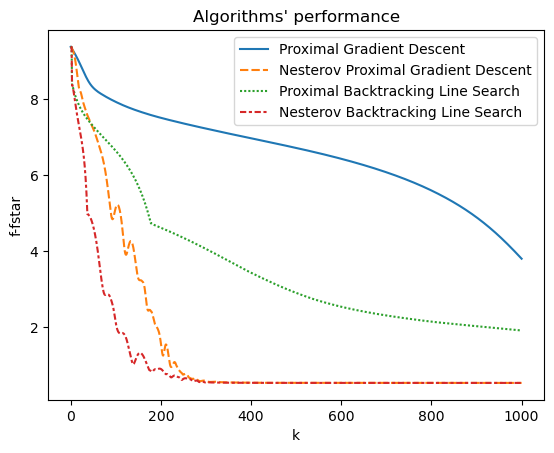

In [11]:
# Plot
sns.lineplot(data=data)
plt.xlabel("k")
plt.ylabel("f-fstar")
plt.title("Algorithms' performance")

In [12]:
# 4f 
testRatings = np.loadtxt('movies/testRatings.txt', delimiter=',')
testRatings = np.insert(testRatings, 0, values=1, axis=1)
testRatings

array([[1., 4., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [13]:
testLabels = np.loadtxt('movies/testLabels.txt', delimiter=',')

In [14]:
# Classification error
((testRatings @ pgd.beta > 0).astype(int) != testLabels).sum()

69

In [15]:
y = (testRatings @ pgd.beta < 0)
under40 = testRatings[y, 1:]

In [16]:
group = np.unique(groupLabels[1:])
groupSlice = [0]
for i in group:
    count = 0
    for j in groupLabels:
        if i == j:
            count += 1
    groupSlice.append(groupSlice[-1] + count)
    
genre = []
for i in range(len(groupSlice)-1):
    genre.append(under40[:, groupSlice[i]:groupSlice[i+1]].sum())
genre = np.array(genre)
maxRate = np.where(genre==genre.max())[0][0]

In [17]:
# Most important movie genre
np.loadtxt('movies/groupTitles.txt', delimiter=',', dtype=str)[maxRate]

'Drama'